# ML Monitoring - Feature importance weighted drift detection and automated-retraining

## Overview

Every model over time is impacted by model performance decay due to data drift and concept drift. One of many solution is to perform drift detection and set up automated retraining of the model. Drift in every feature does't have the same impact on model performance. In this project we combine feature importance of a particular feature with its drift score obtained through statistical test to determine wether to retrain model or not. Thus model will be retrained only when there is drift on features with higher importance and also when feature with lower importance faces higher data drift.

## Dataset:

* Contains warehouse demand data from 2017-01-01 to 2020-11-15
* Working with preprocessed data
* No data leakage as missing values were filled without requirement of any transformation

## Assumptions

* Initial model deployment on march 2019
* True labels/ actual demand available over the weekend
* Model monitored on weekly basis

## Libraries

In [186]:
import pandas as pd
import numpy as np
from datetime import date,datetime,timedelta
from sklearn.model_selection import train_test_split
from rdt import HyperTransformer
import xgboost as xgb
import optuna
import traceback
import shap
import pickle
import logging
from importlib import reload
import logging
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from evidently import ColumnMapping
from evidently.analyzers.stattests import StatTest
from evidently.dashboard import Dashboard
from evidently.dashboard.tabs import DataDriftTab, CatTargetDriftTab, NumTargetDriftTab, RegressionPerformanceTab
from evidently.options import DataDriftOptions
from evidently.model_profile import Profile
from evidently.model_profile.sections import DataDriftProfileSection, NumTargetDriftProfileSection
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.express as px
import os
import json
import mlflow
from functools import wraps
from mlflow.tracking import MlflowClient
import plotly.io as pio
# remove static rendering to allow interactive mode
pio.renderers.default = "svg"
%matplotlib inline

In [187]:
# set up logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%I:%M:%S')

In [188]:
# mlflow runner
def mlflow_runner(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        # log into MLflow
        client = MlflowClient()
        experiment_name = kwargs['experiment_name']
        try:
            mlflow.set_experiment(experiment_name)
        except Exception:
            logging.error('Experiment does not exists')
            logging.error('Stack trace:{}'.format(traceback.format_exc()))
            experiment_id = mlflow.create_experiment(experiment_name)
            mlflow.set_experiment(experiment_name)
        finally:
            with mlflow.start_run() as run:
                rv = func(*args, **kwargs)
            return rv

    return wrapper

## Data

### Load data

In [189]:
df = pd.read_csv('cpp_demand_forecasting_clean_data_v2.csv', index_col=0)

In [190]:
logging.info(f'dataset shape : {df.shape}')

09:45:10 INFO:dataset shape : (13315, 33)


In [191]:
# set random state
rng = np.random.RandomState(0)

In [192]:
df.head(2)

,date,warehouse_ID,Latitude,Longitude,Product_Type,year,month,is_weekend,is_warehouse_closed,daily_dispatch_count,...,statewise_land_area_per_sqmile,statewise_population_per_sqmile,statewise_geographic_region,geographic_region_division,statewise_median_age,statewise_median_household_income,total_count,yearly_count,monthly_count,weekly_count
ID,,,,,,,,,,,,,,,,,,,,,
0x2710,2017-01-01,WH_0x3e9,41.681471,-72.794746,Type_A,2017,1,Yes,No,5.5,...,4842,744.722016,new_england,north_east,41.2,78833,0,0,0,0
0x33e6,2017-01-01,WH_0x3ea,38.749077,-105.183060,Type_A,2017,1,Yes,No,6.1,...,103642,56.078318,mountain,west,37.3,41053,0,0,0,0


In [193]:
df.date = pd.to_datetime(df.date)

<b> Data available during initial model deployment is from 2017-01-01 to 2019-03-01

In [194]:
intial_df = df[df.date < datetime(2019,3,1)]

In [195]:
# Split the dataset
train_df, test_df = train_test_split(intial_df,
                                     test_size=0.3,
                                     shuffle=False,
                                     random_state=rng)
eval_df, serve_df = train_test_split(test_df,
                                     test_size=0.5,
                                     shuffle=False,
                                     random_state=rng)

In [196]:
logging.info(f'train_df shape : {train_df.shape}')
logging.info(f'eval_df shape : {eval_df.shape}')
logging.info(f'serve_df shape : {serve_df.shape}')

09:45:30 INFO:train_df shape : (2794, 33)
09:45:30 INFO:eval_df shape : (599, 33)
09:45:30 INFO:serve_df shape : (599, 33)


### Data preprocessing

In [197]:
def split_features_target(df):
    target =  'daily_dispatch_count'
    drop_feats = ['weekly_dispatch_count']
    y = df[target]
    X = df.drop(columns = drop_feats+[target])
    return X,y

In [198]:
X,y = split_features_target(train_df)
X_eval,y_eval = split_features_target(eval_df)
X_serve,y_serve = split_features_target(serve_df)

### Data transformation

In [199]:
ht = HyperTransformer()

In [200]:
ht.detect_initial_config(data=X)

Detecting a new config from the data ... SUCCESS
Setting the new config ... SUCCESS
Config:
{
    "sdtypes": {
        "date": "datetime",
        "warehouse_ID": "categorical",
        "Latitude": "numerical",
        "Longitude": "numerical",
        "Product_Type": "categorical",
        "year": "numerical",
        "month": "numerical",
        "is_weekend": "categorical",
        "is_warehouse_closed": "categorical",
        "week": "numerical",
        "state": "categorical",
        "county": "categorical",
        "state_cases": "numerical",
        "state_deaths": "numerical",
        "county_cases": "numerical",
        "county_deaths": "numerical",
        "day_of_week": "numerical",
        "days_since_warehouse_started": "numerical",
        "state_abbr": "categorical",
        "is_holiday": "numerical",
        "statewise_population": "numerical",
        "statewise_land_area_per_sqmile": "numerical",
        "statewise_population_per_sqmile": "numerical",
        "statew

In [201]:
ht.fit(X)
X_transformed = ht.transform(X)
X_eval_transformed = ht.transform(X_eval)
X_serve_transformed = ht.transform(X_serve)

d:\anaconda\envs\anaconda_env\lib\site-packages\rdt\transformers\categorical.py:182: UserWarning:

The data contains 116 new categories that were not seen in the original data (examples: {'WH_0x3ed'}). Assigning them random values. If you want to model new categories, please fit the transformer again with the new data.

d:\anaconda\envs\anaconda_env\lib\site-packages\rdt\transformers\categorical.py:182: UserWarning:

The data contains 116 new categories that were not seen in the original data (examples: {'florida'}). Assigning them random values. If you want to model new categories, please fit the transformer again with the new data.

d:\anaconda\envs\anaconda_env\lib\site-packages\rdt\transformers\categorical.py:182: UserWarning:

The data contains 116 new categories that were not seen in the original data (examples: {'miami-dade'}). Assigning them random values. If you want to model new categories, please fit the transformer again with the new data.

d:\anaconda\envs\anaconda_env\lib

## Modelling

In [202]:
@mlflow_runner
def fit_model(X,y, X_test,y_test, params=None,mlflow_log = False, experiment_name=None):
    if params:
        reg = xgb.XGBRegressor(**params)
    else:
        reg = xgb.XGBRegressor()
    reg.fit(X,y,eval_set=[(X_test,y_test)],early_stopping_rounds=10,verbose=False)
    if mlflow_log:
        mlflow.log_dict(reg.get_params(),'xgboost_regressor_params')
        
    return reg

In [203]:
reg = fit_model(X_transformed,y, X_eval_transformed,y_eval, mlflow_log=True,experiment_name='warehouse_demand_forecasting')

d:\anaconda\envs\anaconda_env\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



#### Model evaluation

In [204]:
def rewrite_name(df_type, error_type):
    return f"{df_type}{'_'}{error_type}"

def get_scores(y_actual, y_predicted,df_type='train'):
    #y_predicted = np.expm1(y_predicted)
    #y_actual = np.expm1(y_actual)
    rmse = mean_squared_error(y_actual, y_predicted, squared=False)
    mse = mean_squared_error(y_actual, y_predicted, squared=True)
    mae = mean_absolute_error(y_actual, y_predicted)
    mape = mean_absolute_percentage_error(y_actual, y_predicted)
    return {rewrite_name(df_type, 'rmse'):rmse, rewrite_name(df_type, 'mse'):mse, rewrite_name(df_type, 'mae'):mae, rewrite_name(df_type, 'mape'):mape}

def dataset_results(X,y, model, df_type):

    y_pred = model.predict(X)
    
    return get_scores(y,y_pred,df_type)
    

#### Train score

In [205]:
dataset_results(X_transformed,y, reg, 'train')

{'train_rmse': 0.8588220704988938,
 'train_mse': 0.7375753487760068,
 'train_mae': 0.6316703897078888,
 'train_mape': 0.0849176099824632}

#### Eval score

In [206]:
dataset_results(X_eval_transformed,y_eval, reg, 'eval')

{'eval_rmse': 0.9780817870850148,
 'eval_mse': 0.9566439822274162,
 'eval_mae': 0.7291432013694751,
 'eval_mape': 0.11933018414067095}

#### Serve score

In [207]:
dataset_results(X_serve_transformed,y_serve, reg, 'serve')

{'serve_rmse': 1.01830436396952,
 'serve_mse': 1.0369437776793686,
 'serve_mae': 0.7832677500474831,
 'serve_mape': 0.16869041564386766}

#### Final model trained using data from 2017-01-01 to 2019-03-01

In [306]:
final_X, final_y = split_features_target(intial_df)
ht.fit(final_X)
final_X_transform = ht.transform(final_X)
reg_final = fit_model(final_X_transform,final_y, X_eval_transformed,y_eval, mlflow_log=True,experiment_name='warehouse_demand_forecasting')

d:\anaconda\envs\anaconda_env\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



In [369]:
final_X_transform.head()

,date.value,warehouse_ID.value,Latitude.value,Longitude.value,Product_Type.value,year.value,month.value,is_weekend.value,is_warehouse_closed.value,week.value,...,statewise_land_area_per_sqmile.value,statewise_population_per_sqmile.value,statewise_geographic_region.value,geographic_region_division.value,statewise_median_age.value,statewise_median_household_income.value,total_count.value,yearly_count.value,monthly_count.value,weekly_count.value
ID,,,,,,,,,,,,,,,,,,,,,
0x2710,1.483229e+18,0.151804,41.681471,-72.794746,0.295842,2017,1,0.857966,0.5,52,...,4842,744.722016,0.667335,0.681864,41.2,78833,0,0,0,0
0x33e6,1.483229e+18,0.455411,38.749077,-105.183060,0.295842,2017,1,0.857966,0.5,52,...,103642,56.078318,0.257766,0.257766,37.3,41053,0,0,0,0
0x2711,1.483315e+18,0.151804,41.681471,-72.794746,0.295842,2017,1,0.357966,0.5,1,...,4842,744.722016,0.667335,0.681864,41.2,78833,1,1,1,0
0x33e7,1.483315e+18,0.455411,38.749077,-105.183060,0.295842,2017,1,0.357966,0.5,1,...,103642,56.078318,0.257766,0.257766,37.3,41053,1,1,1,0
0x2712,1.483402e+18,0.151804,41.681471,-72.794746,0.295842,2017,1,0.357966,0.5,1,...,4842,744.722016,0.667335,0.681864,41.2,78833,2,2,2,1


In [370]:
final_y.head()

ID
0x2710    5.5
0x33e6    6.1
0x2711    4.8
0x33e7    6.7
0x2712    5.8
Name: daily_dispatch_count, dtype: float64

### Feature attribution weighted drift detection

In [307]:
def get_feature_importance(model, X):
    # DF, based on which importance is checked

    # Explain model predictions using shap library:
    explainer = shap.TreeExplainer(model)
    shap_scores = explainer.shap_values(X)

    # mean of absolute shap values for every feature
    mean_abs_shap_values = pd.Series(
        np.abs(shap_scores).mean(axis=0),
        index=X.columns).sort_values(ascending=False)
    return mean_abs_shap_values

In [308]:
def get_relative_feature_importance_to_max(feature_importance):
    
    # maximum feature importance
    max_feature_importance = feature_importance.max()

    # relative_feature_importance_to_max is relative feature importance w.r.t max_feature_importance
    relative_feature_importance_to_max = feature_importance / max_feature_importance
    return relative_feature_importance_to_max.to_dict()

In [309]:
numerical_features = [
    'statewise_population_per_sqmile', 'state_cases', 'state_deaths'
]
numerical_features_value = [
    feature + '.value' for feature in numerical_features
]
categorical_features = [
    'warehouse_ID', 'Product_Type', 'is_weekend', 'is_warehouse_closed',
    'state', 'day_of_week', 'is_holiday', 'county'
]
categorical_features_value = [
    feature + '.value' for feature in categorical_features
]
column_mapping = ColumnMapping(id='ID',
                               datetime='date',
                               numerical_features=numerical_features_value,
                               categorical_features=categorical_features_value,
                               task='regression',
                               target='daily_dispatch_count',
                               prediction='y_pred')

In [310]:
def get_drift_profile(reference, production, profile, mlflow_log=False):

    drift_profile = Profile(sections=[profile()])
    drift_profile.calculate(reference,
                                 production,
                                 column_mapping=column_mapping)
    report = drift_profile.json()
    drift_profile_report = json.loads(report)
    
    if mlflow_log:
        if profile == DataDriftProfileSection:
            name = 'data_drift_profile'
        elif profile == NumTargetDriftProfileSection:
            name = 'num_target_drift_profile'
        else:
            pass
        mlflow.log_dict(drift_profile_report, f"{name}.json")
    
    
    return drift_profile_report

In [311]:
def get_data_drift(drift_profile):

    drifts = []
    for feature in column_mapping.numerical_features + column_mapping.categorical_features:
        drifts.append(
            (feature, drift_profile['data_drift']['data']['metrics'][feature]['drift_score'], 
             drift_profile['data_drift']['data']['metrics'][feature]['stattest_name'], 
             drift_profile['data_drift']['data']['metrics'][feature]['drift_detected']))
    return  pd.DataFrame(
        drifts,
        columns=['feature', 'drift_score', 'stattest_name', 'drift_detected'])

In [312]:
def get_weighted_data_drift_score(drift, feature_importance, relative_feature_importance_to_max_dict, threshold, stattest_type):
    
    #feature_importance
    drift['feature_importance'] = drift['feature'].map(feature_importance)
    
    # map relative feature importance
    drift['relative_feature_importance'] = drift['feature'].map(relative_feature_importance_to_max_dict)
    if stattest_type == 'p_value':
        # relative feature importance weighted drift score
        inverse_feature_importance_wrt_max_feature_importance = (drift.relative_feature_importance.max() / drift.relative_feature_importance)
        drift['feature_importance_weighted_drift_score'] = (drift.drift_score * inverse_feature_importance_wrt_max_feature_importance).replace(np.inf, 1)
        #drift['feature_importance_weighted_drift_score'] = drift.apply(lambda x:1 if x['relative_feature_importance']<=0.0 else x['feature_importance_weighted_drift_score'], axis=1)
        # drift detection based on the weighted drift score based on threshold
        drift['feature_importance_weighted_drift_detected'] = drift[
            'feature_importance_weighted_drift_score'] < threshold
    else:
        # relative feature importance weighted drift score
        drift['feature_importance_weighted_drift_score'] = drift[
            'relative_feature_importance'] * drift['drift_score']

        # drift detection based on the weighted drift score based on threshold
        drift['feature_importance_weighted_drift_detected'] = drift[
            'feature_importance_weighted_drift_score'] > threshold

    return drift

In [313]:
def is_weighted_data_drift_detected(data_drift_profile, production,  model):
    drift_detected = False
    
    feature_importance = get_feature_importance(model, production)
    # relative feature importance based on mean shap values
    relative_feature_importance_to_max_dict = get_relative_feature_importance_to_max(feature_importance)
    drift_scores = get_data_drift(data_drift_profile)
    stattest_type = drift_scores['stattest_name'].iloc[0].split()[1]
    if stattest_type == 'p_value':
        threshold = 0.05
    else:
        threshold = 0.1
    weighted_drift_scores = get_weighted_data_drift_score(drift_scores, feature_importance, relative_feature_importance_to_max_dict,
                                                     threshold, stattest_type)

    if weighted_drift_scores['feature_importance_weighted_drift_detected'].sum(
    ) > 0:
        drift_detected = True
    else:
        drift_detected = False
    return drift_detected, weighted_drift_scores

In [314]:
def overlay_distribution(data1, data2, feature,  opacity=0.5, plot_display = True, mlflow_log=False):
    normalization_type = 'probability density'
    fig = go.Figure()
    fig.add_trace(go.Histogram(x=data1, name="training",
                  histnorm=normalization_type))
    fig.add_trace(go.Histogram(x=data2, name="production",
                  histnorm=normalization_type))
    feature = feature.split('.')[0]
    # Overlay both histograms
    fig.update_layout(barmode='overlay', title=feature+" Distribution",
                      xaxis_title=feature,
                      yaxis_title=normalization_type, autosize=False,
                      width=700,
                      height=300)
    # Reduce opacity to see both histograms
    fig.update_traces(opacity=opacity)
    if mlflow_log:
        mlflow.log_figure(fig, f"{feature}_Distribution.html")
    if plot_display:
        fig.show()


In [315]:
def display_drifted_features(reference, production, drift_df, plot_display = False, mlflow_log = False):
    reference_rdt = ht.reverse_transform(reference)
    production_rdt = ht.reverse_transform(production)
    for index, row in drift_df.iterrows():
        if row['feature_importance_weighted_drift_detected']:

            logging.info(f"drift detected for {row['feature']}")
            logging.info(f"drift_score : {row['drift_score']}")
            logging.info(f"stattest_name : {row['stattest_name']}")
            logging.info(f"raw_feature_importance : {row['feature_importance']}") 
            logging.info(f"relative_feature_importance : {row['relative_feature_importance']}") 
            logging.info(f"feature_importance_weighted_drift_score : {row['feature_importance_weighted_drift_score']}")
            
            overlay_distribution(reference_rdt[row['feature'].split('.')[0]], production_rdt[row['feature'].split('.')[0]], row['feature'], opacity = .4, 
            plot_display = plot_display, mlflow_log=True)
        if mlflow_log:
                mlflow.log_param(f"{row['feature']}_feature_importance_weighted_drift_detected", row['feature_importance_weighted_drift_detected'])
                mlflow.log_param(f"{row['feature']}_drift_score", row['drift_score'])
                mlflow.log_param(f"{row['feature']}_stattest_name", row['stattest_name'])
                mlflow.log_param(f"{row['feature']}_raw_feature_importance", row['feature_importance'])
                mlflow.log_param(f"{row['feature']}_relative_feature_importance", row['relative_feature_importance'])
                mlflow.log_param(f"{row['feature']}_feature_importance_weighted_drift_score", row['feature_importance_weighted_drift_score'])

    

In [316]:
def display_target_drift(y_reference, y_production, target_name, target_drift_detected, drift_score, stattest_type, plot_display = False, mlflow_log = False):
    logging.info(f"Target drift detected for for {target_name}")
    logging.info(f"drift_score : {drift_score}")
    logging.info(f"stattest_name : {stattest_type}")
    if mlflow_log:
        mlflow.log_param(f"{target_name}_drift_detected", target_drift_detected)
        mlflow.log_param(f"{target_name}_target_drift_score", drift_score)
        mlflow.log_param(f"{target_name}_target_stattest_name", stattest_type)
    overlay_distribution(y_reference, y_production, target_name, opacity = .4, plot_display = plot_display, mlflow_log=True)
            

#### How feature importance weighted data drift is calculated?



In [317]:
# set up reference and prod data
reference_data = X_transformed.sample(500)
prod_data = X_eval_transformed.sample(500)


In [318]:
# Perform statistical tests and obtain data drift profile
data_drift_profile = get_drift_profile(reference_data, prod_data,
                                           DataDriftProfileSection)
# get drift profile in tablular format
drift_scores = get_data_drift(data_drift_profile)

drift_scores.sort_values(by='drift_score')

,feature,drift_score,stattest_name,drift_detected
0,statewise_population_per_sqmile.value,1.347613e-13,chi-square p_value,True
3,warehouse_ID.value,1.347613e-13,chi-square p_value,True
7,state.value,1.347613e-13,chi-square p_value,True
10,county.value,1.347613e-13,chi-square p_value,True
4,Product_Type.value,3.729947e-06,Z-test p_value,True
9,is_holiday.value,1.427864e-02,Z-test p_value,True
5,is_weekend.value,7.272336e-01,Z-test p_value,False
8,day_of_week.value,8.162967e-01,chi-square p_value,False
1,state_cases.value,1.000000e+00,Z-test p_value,False
2,state_deaths.value,1.000000e+00,Z-test p_value,False


##### drift detected without feature importance wightage for these features - statewise_population_per_sqmile.value, warehouse_ID.value, Product_Type.value, state.value, county.value	

In [319]:
# Obtain feature importance
feature_importance = get_feature_importance(reg, X_eval_transformed)
feature_importance.head(5)

d:\anaconda\envs\anaconda_env\lib\site-packages\xgboost\core.py:90: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.



Product_Type.value    2.320021
is_weekend.value      0.442543
warehouse_ID.value    0.343991
day_of_week.value     0.204179
date.value            0.159709
dtype: float32

In [320]:
# Convert feature importance to relative feature importance w.r.t most important feature for the model(Product_Type.value)
relative_feature_importance_to_max_dict = get_relative_feature_importance_to_max(feature_importance)
pd.Series(relative_feature_importance_to_max_dict).sort_values(ascending=False).head(5)

Product_Type.value    1.000000
is_weekend.value      0.190749
warehouse_ID.value    0.148271
day_of_week.value     0.088007
date.value            0.068839
dtype: float64

In [321]:
weighted_drift_scores = get_weighted_data_drift_score(drift_scores, feature_importance, relative_feature_importance_to_max_dict,
                                                     threshold = 0.05, stattest_type = 'p_value')
weighted_drift_scores.sort_values(by='feature_importance_weighted_drift_score')

,feature,drift_score,stattest_name,drift_detected,feature_importance,relative_feature_importance,feature_importance_weighted_drift_score,feature_importance_weighted_drift_detected
3,warehouse_ID.value,1.347613e-13,chi-square p_value,True,0.343991,0.148271,9.088875e-13,True
0,statewise_population_per_sqmile.value,1.347613e-13,chi-square p_value,True,0.054936,0.023679,5.691117e-12,True
4,Product_Type.value,3.729947e-06,Z-test p_value,True,2.320021,1.000000,3.729947e-06,True
1,state_cases.value,1.000000e+00,Z-test p_value,False,0.000000,0.000000,1.000000e+00,False
2,state_deaths.value,1.000000e+00,Z-test p_value,False,0.000000,0.000000,1.000000e+00,False
6,is_warehouse_closed.value,1.000000e+00,Z-test p_value,False,0.000000,0.000000,1.000000e+00,False
7,state.value,1.347613e-13,chi-square p_value,True,0.000000,0.000000,1.000000e+00,False
10,county.value,1.347613e-13,chi-square p_value,True,0.000000,0.000000,1.000000e+00,False
5,is_weekend.value,7.272336e-01,Z-test p_value,False,0.442543,0.190749,3.812507e+00,False
8,day_of_week.value,8.162967e-01,chi-square p_value,False,0.204179,0.088007,9.275321e+00,False


##### drift detected with feature importance wightage for these features - statewise_population_per_sqmile.value, warehouse_ID.value, Product_Type.value	

<b>state.value and county.value are not detected because of high feature importance weighted p_value</b>

##### drift detected without feature importance wightage for these features - statewise_population_per_sqmile.value, warehouse_ID.value, Product_Type.value, state.value, county.value	

#### Test for target drift

In [322]:
def determine_test_type(reference):

    num_data = reference.shape[0]

    if num_data <= 1000:
        return 'p_value'
    else:
        return 'distance'

In [323]:
def test_target_drift(X_reference, y_reference, X_production, y_production, plot_display = False, mlflow_log = False):
    target_drift_detected = False
    # get target drift report
    if column_mapping.task == 'regression':
        profile = NumTargetDriftProfileSection
        drift_name = 'num_target_drift'
    else:
        pass
    target_drift_profile = get_drift_profile(X_reference.join(y_reference), X_production.join(y_production), profile, mlflow_log)
    
    drift_score = target_drift_profile[drift_name]['data']['metrics']['target_drift']
    target_name = target_drift_profile[drift_name]['data']['utility_columns']['target']
    stattest_type = determine_test_type(X_reference)
    if stattest_type == 'p_value':
        threshold = 0.05
        if drift_score <= threshold:

            target_drift_detected = True

    else:
        threshold = 0.1
        if drift_score >= threshold:

            target_drift_detected = True
   
    if mlflow_log:
        display_target_drift(y_reference, y_production, target_name, target_drift_detected, drift_score, stattest_type, plot_display, mlflow_log = True)
    return target_drift_detected
      

In [324]:
def test_for_drift(X_reference, y_reference, X_production, y_production, model, plot_display = False, mlflow_log = False):

    
    target_drift_detected = test_target_drift(X_reference, y_reference, X_production, y_production, mlflow_log)

    logging.info(f"target drift detect: {target_drift_detected}")
    # get data drift report
    data_drift_profile = get_drift_profile(X_reference, X_production,
                                           DataDriftProfileSection, mlflow_log)
    # data drift detected?
    drift_detected, drift_df = is_weighted_data_drift_detected(data_drift_profile,
                                                     X_production,  model)
    
    if drift_detected:
        logging.info('data set drift detected')
        display_drifted_features(X_reference, X_production, drift_df, plot_display, mlflow_log)
    else:
        logging.info('drift not detected')
    drift_detected = drift_detected or target_drift_detected
    return drift_detected

In [325]:
@mlflow_runner
def test_mlflow(experiment_name):
    # Log parameters
    mlflow.log_param("begin", datetime(2020,1,2))
    mlflow.log_param("end", datetime(2022,1,2))
    mlflow.log_dict(X_transformed.sample(500).to_dict(), 'input_features.json')
    mlflow.log_dict(X_eval_transformed.sample(500).to_dict(), 'target.json')
    return test_for_drift(X_transformed.sample(500), y.sample(500), X_eval_transformed.sample(500), y_eval.sample(500) ,reg, plot_display = True, mlflow_log = True)


11:02:33 INFO:target drift detect: True
d:\anaconda\envs\anaconda_env\lib\site-packages\xgboost\core.py:90: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.

11:02:33 INFO:data set drift detected
11:02:33 INFO:drift detected for statewise_population_per_sqmile.value
11:02:33 INFO:drift_score : 2.1994752167153156e-17
11:02:33 INFO:stattest_name : chi-square p_value
11:02:33 INFO:raw_feature_importance : 0.05471304431557655
11:02:33 INFO:relative_feature_importance : 0.02342214621603489
11:02:33 INFO:feature_importance_weighted_drift_score : 9.390579310829963e-16


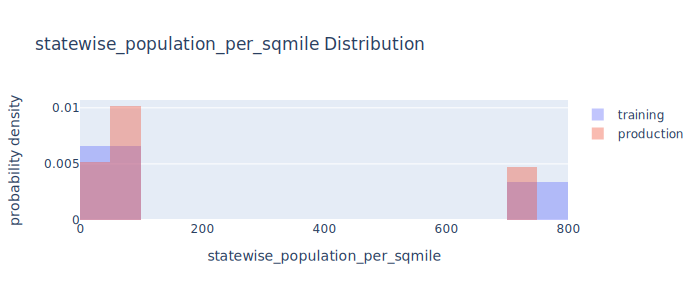

11:02:33 INFO:drift detected for warehouse_ID.value
11:02:33 INFO:drift_score : 2.1994752167153156e-17
11:02:33 INFO:stattest_name : chi-square p_value
11:02:33 INFO:raw_feature_importance : 0.33883628249168396
11:02:33 INFO:relative_feature_importance : 0.14505267143249512
11:02:33 INFO:feature_importance_weighted_drift_score : 1.5163286515125726e-16


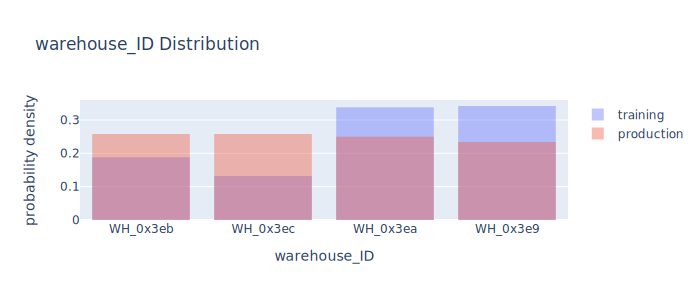

11:02:33 INFO:drift detected for Product_Type.value
11:02:33 INFO:drift_score : 6.285873708211653e-07
11:02:33 INFO:stattest_name : Z-test p_value
11:02:33 INFO:raw_feature_importance : 2.3359534740448
11:02:33 INFO:relative_feature_importance : 1.0
11:02:33 INFO:feature_importance_weighted_drift_score : 6.285873708211653e-07


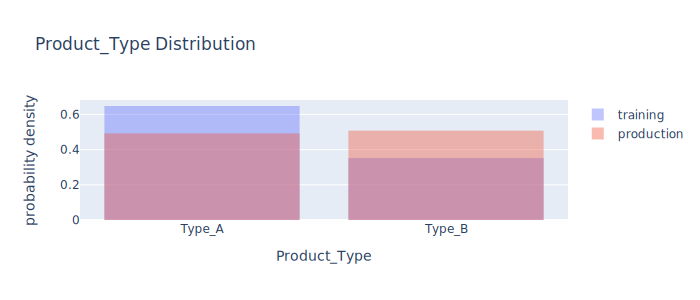

True

In [326]:
test_mlflow(experiment_name = 'mlflow drift detection test')

#### Simulate model on data from 2019-03-01 to 2020-11-15

In [327]:
simulate_df = df[df.date >= datetime(2019,3,1)]

In [354]:
final_X_transform.sample(n=10).index

(3992, 31)

In [374]:
final_y.loc[final_y.index.isin(final_X_transform.sample(n=10).index)]

ID
0x28e6     8.3
0x35c5     4.0
0x2992     8.0
0x2a0f     3.9
0x2a22    10.0
0x42ea     8.7
0x2b5c     6.3
0x2b6b     3.7
0x4e2f     3.6
0x43d4     7.8
Name: daily_dispatch_count, dtype: float64

In [364]:
@mlflow_runner
def simulate_Weekly_experiment(df, model, preds, experiment_name, week_num,plot_display =False):
    # Get weekly data
        global final_X_transform
        global final_y
        row = df.iloc[0]
        dt = row['date']
        start = dt - timedelta(days=row['date'].weekday())
        end = start + timedelta(days=6)
        sub_df = df.set_index('date')[start:end]
        sub_df = sub_df.reset_index().set_index('ID')
        df = df[(df.date.dt.date > end.date())]
        print(f'Experiment week {week_num}')
        print('---------------------------------')
        print(f"Experiment start date : {start.to_pydatetime()}")
        print(f"Experiment end_date : {end.to_pydatetime()}")
        mlflow.log_param('experiment_week',week_num)
        mlflow.log_param('week_begin_experiment_start_date',start)
        mlflow.log_param('week_end_experiment_end_date',end)
        
        # Transform sub_df to X, y
        X_prod,y_prod = split_features_target(sub_df)
        X_prod_transformed = ht.transform(X_prod)
        
        mlflow.log_dict(X_prod_transformed.to_dict(), 'input_features.json')
        mlflow.log_dict(y_prod.to_dict(), 'target.json')
        # weekly_prediction
        weekly_predictions = model.predict(X_prod_transformed)

        mlflow.log_dict(pd.Series(weekly_predictions,name=y_prod.name, index = y_prod.index).to_dict(),'weekly_predictions.json')
        # Predict for X,y
        scores_dict = get_scores(y_prod,weekly_predictions,f"weekly")
        mlflow.log_metrics(scores_dict)
        preds.extend(weekly_predictions.tolist())
        ht.fit(X_prod)
        reference_data = final_X_transform.sample(n = X_prod_transformed.shape[0])
        
        print(reference_data.index)
        print(final_y.index)
        if test_for_drift(reference_data, final_y.loc[final_y.index.isin(reference_data.index)], X_prod_transformed, y_prod.loc[reference_data.index], reg, plot_display, mlflow_log=True):
            # retrain model
            # test for drift an
            logging.info('Retraining model')
            model.fit(X_prod_transformed, y_prod)
        else:
            logging.info('No Drift detection')
        final_X_transform = final_X_transform.append(X_prod_transformed)
        final_y = final_y.append(y_prod)
        return df, preds

In [365]:
weighted_drift_scores[['feature','drift_detected','relative_feature_importance','feature_importance_weighted_drift_score','feature_importance_weighted_drift_detected']]

,feature,drift_detected,relative_feature_importance,feature_importance_weighted_drift_score,feature_importance_weighted_drift_detected
0,statewise_population_per_sqmile.value,True,0.023679,5.691117e-12,True
1,state_cases.value,False,0.000000,1.000000e+00,False
2,state_deaths.value,False,0.000000,1.000000e+00,False
3,warehouse_ID.value,True,0.148271,9.088875e-13,True
4,Product_Type.value,True,1.000000,3.729947e-06,True
5,is_weekend.value,False,0.190749,3.812507e+00,False
6,is_warehouse_closed.value,False,0.000000,1.000000e+00,False
7,state.value,True,0.000000,1.000000e+00,False
8,day_of_week.value,False,0.088007,9.275321e+00,False
9,is_holiday.value,True,0.000773,1.848090e+01,False


In [366]:
def simulate_model(df, model, experiment_name, plot_display =False):
    
    preds = []
    df = df.reset_index()
    current_df = df
    week_num = 1
    while current_df.shape[0] > 0:

        current_df, preds = simulate_Weekly_experiment(current_df, model, preds, experiment_name = experiment_name, 
        week_num=week_num, plot_display = plot_display)
        week_num +=1
    return preds   

In [375]:
preds = simulate_model(simulate_df, reg_final, experiment_name='weekly_ml_monitoring')

Experiment week 1
---------------------------------
Experiment start date : 2019-02-25 00:00:00
Experiment end_date : 2019-03-03 00:00:00
Index(['0x431e', '0x36f4', '0x4e55', '0x35a6', '0x4c39', '0x3656', '0x36b8',
       '0x2b4d', '0x4cd2', '0x4de2', '0x42d2', '0x369a', '0x43d8', '0x42a2',
       '0x43e5', '0x56b9', '0x4dca', '0x28eb', '0x428b', '0x29da', '0x3734',
       '0x4c87', '0x370e', '0x275d', '0x3615', '0x2ae9', '0x56b5', '0x4d96',
       '0x43ed', '0x4d56'],
      dtype='object', name='ID')
Index(['0x2710', '0x33e6', '0x2711', '0x33e7', '0x2712', '0x33e8', '0x2713',
       '0x33e9', '0x2714', '0x33ea',
       ...
       '0x2bca', '0x2bcb', '0x38a0', '0x38a1', '0x4408', '0x4409', '0x4e80',
       '0x4e81', '0x570e', '0x570f'],
      dtype='object', name='ID', length=3992)


KeyError: "None of [Index(['0x431e', '0x36f4', '0x4e55', '0x35a6', '0x4c39', '0x3656', '0x36b8',\n       '0x2b4d', '0x4cd2', '0x4de2', '0x42d2', '0x369a', '0x43d8', '0x42a2',\n       '0x43e5', '0x56b9', '0x4dca', '0x28eb', '0x428b', '0x29da', '0x3734',\n       '0x4c87', '0x370e', '0x275d', '0x3615', '0x2ae9', '0x56b5', '0x4d96',\n       '0x43ed', '0x4d56'],\n      dtype='object', name='ID')] are in the [index]"

#### Drift detection graphs

In [256]:
expirement_results = mlflow.search_runs(experiment_names=['weekly_ml_monitoring'])

In [257]:
expirement_results.set_index('params.week_end_experiment_end_date',inplace=True)
expirement_results.sort_index(ascending=True,inplace=True)

In [258]:
expirement_results

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.weekly_mse,metrics.weekly_rmse,metrics.weekly_mape,metrics.weekly_mae,...,params.is_holiday.value_feature_importance_weighted_drift_detected,params.warehouse_ID.value_raw_feature_importance,params.statewise_population_per_sqmile.value_raw_feature_importance,params.is_warehouse_closed.value_drift_score,params.is_weekend.value_raw_feature_importance,params.Product_Type.value_feature_importance_weighted_drift_detected,params.day_of_week.value_relative_feature_importance,tags.mlflow.source.type,tags.mlflow.user,tags.mlflow.source.name
params.week_end_experiment_end_date,,,,,,,,,,,,,,,,,,,,,
2019-03-03 00:00:00,3f62247c967f4572828f1f24d0dddf87,2,FINISHED,file:///C:/Users/shree/projects/ML_Monitoring/...,2022-06-28 06:19:06.956000+00:00,2022-06-28 06:19:07.990000+00:00,0.578857,0.760827,1.162311e-01,0.624194,...,False,0.3413332402706146,0.07447593659162521,0.0,0.5882567763328552,True,0.10281465202569962,LOCAL,shree,d:\anaconda\envs\anaconda_env\lib\site-package...
2019-03-03 00:00:00,233e6d65806c4765ab1730f4fea499a2,2,FINISHED,file:///C:/Users/shree/projects/ML_Monitoring/...,2022-06-28 06:24:19.019000+00:00,2022-06-28 06:24:20.097000+00:00,0.578857,0.760827,1.162311e-01,0.624194,...,False,0.3413332402706146,0.07447593659162521,0.0,0.5882567763328552,True,0.10281465202569962,LOCAL,shree,d:\anaconda\envs\anaconda_env\lib\site-package...
2019-03-03 00:00:00,388f8b8352ef44e8b844374d09dba615,2,FAILED,file:///C:/Users/shree/projects/ML_Monitoring/...,2022-06-29 04:40:20.462000+00:00,2022-06-29 04:40:20.720000+00:00,0.578857,0.760827,1.162311e-01,0.624194,...,None,None,None,None,None,None,None,LOCAL,shree,d:\anaconda\envs\anaconda_env\lib\site-package...
2019-03-03 00:00:00,8e004dbf8c0f4558b0347b1382d65253,2,FAILED,file:///C:/Users/shree/projects/ML_Monitoring/...,2022-06-29 04:43:45.010000+00:00,2022-06-29 04:43:45.304000+00:00,3.833653,1.957972,2.421320e-01,1.537056,...,None,None,None,None,None,None,None,LOCAL,shree,d:\anaconda\envs\anaconda_env\lib\site-package...
2019-03-03 00:00:00,920ee66b8ff742618acb68271a534ce6,2,FAILED,file:///C:/Users/shree/projects/ML_Monitoring/...,2022-06-29 04:45:06.945000+00:00,2022-06-29 04:45:07.202000+00:00,3.833653,1.957972,2.421320e-01,1.537056,...,None,None,None,None,None,None,None,LOCAL,shree,d:\anaconda\envs\anaconda_env\lib\site-package...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-08 00:00:00,bf52a02f23da4a3887089f86ffdd8268,2,FINISHED,file:///C:/Users/shree/projects/ML_Monitoring/...,2022-06-29 04:53:23.029000+00:00,2022-06-29 04:53:24.346000+00:00,6.163768,2.482694,1.204077e+14,1.924483,...,False,0.36078178882598877,0.0559806190431118,0.8145357185616025,0.4534967839717865,True,0.08779085427522659,LOCAL,shree,d:\anaconda\envs\anaconda_env\lib\site-package...
2020-11-15 00:00:00,76f032413aa94c08bc6259f2e248e054,2,FINISHED,file:///C:/Users/shree/projects/ML_Monitoring/...,2022-06-28 06:20:51.172000+00:00,2022-06-28 06:20:52.588000+00:00,6.485387,2.546642,1.597630e+14,1.960821,...,False,0.3696640431880951,0.055968452244997025,0.8325546111576977,0.4301363229751587,True,0.0870433822274208,LOCAL,shree,d:\anaconda\envs\anaconda_env\lib\site-package...
2020-11-15 00:00:00,94c8438adddd465ca4505315ffb37bc1,2,FINISHED,file:///C:/Users/shree/projects/ML_Monitoring/...,2022-06-28 06:26:13.483000+00:00,2022-06-28 06:26:14.636000+00:00,6.485387,2.546642,1.597630e+14,1.960821,...,False,0.3696640431880951,0.055968452244997025,0.8325546111576977,0.4301363229751587,True,0.0870433822274208,LOCAL,shree,d:\anaconda\envs\anaconda_env\lib\site-package...


In [259]:
expirement_results.artifact_uri.iloc[0]

'file:///C:/Users/shree/projects/ML_Monitoring/Feature_importance_weighted_drift_detection_and_automated_retraining/mlruns/2/3f62247c967f4572828f1f24d0dddf87/artifacts'

In [260]:
all_cols = expirement_results.columns
drift_detection_cols = all_cols[all_cols.str.endswith('drift_detected')]
drift_score_cols = all_cols[all_cols.str.endswith('drift_score')]

In [261]:
for col in drift_detection_cols:
    expirement_results[col] = expirement_results[col].replace([None],False).replace('False',False).astype(bool).astype(int)

In [262]:
for col in drift_score_cols:
    expirement_results[col] = expirement_results[col].replace([None],0).astype(float)

In [263]:
drift_detected_cols = []
for col in drift_detection_cols:
    if expirement_results[col].sum() > 0:
        drift_detected_cols.append(col)


In [264]:
drift_detected_cols

['params.warehouse_ID.value_feature_importance_weighted_drift_detected',
 'params.is_weekend.value_feature_importance_weighted_drift_detected',
 'params.Product_Type.value_feature_importance_weighted_drift_detected']

In [265]:
drift_detected_features = pd.Series(drift_detected_cols).map(lambda x:x.split('.')[1]).str.replace('_drift_detected','').to_list()

In [266]:
drift_detected_experiment_cols = all_cols[[any([(feature in col) for feature in drift_detected_features]) for col in all_cols.to_list()]]

In [267]:
drift_detected_experiment_results = expirement_results[drift_detected_experiment_cols]

In [268]:
fig = px.line(drift_detected_experiment_results,  y='params.daily_dispatch_count_target_drift_score', markers=True)
fig.show()

ValueError: Value of 'y' is not the name of a column in 'data_frame'. Expected one of ['params.Product_Type.value_stattest_name', 'params.Product_Type.value_feature_importance_weighted_drift_score', 'params.is_weekend.value_stattest_name', 'params.warehouse_ID.value_drift_score', 'params.is_weekend.value_relative_feature_importance', 'params.warehouse_ID.value_relative_feature_importance', 'params.is_weekend.value_drift_score', 'params.warehouse_ID.value_feature_importance_weighted_drift_score', 'params.is_weekend.value_feature_importance_weighted_drift_score', 'params.Product_Type.value_raw_feature_importance', 'params.Product_Type.value_drift_score', 'params.Product_Type.value_relative_feature_importance', 'params.warehouse_ID.value_feature_importance_weighted_drift_detected', 'params.is_weekend.value_feature_importance_weighted_drift_detected', 'params.warehouse_ID.value_stattest_name', 'params.warehouse_ID.value_raw_feature_importance', 'params.is_weekend.value_raw_feature_importance', 'params.Product_Type.value_feature_importance_weighted_drift_detected'] but received: params.daily_dispatch_count_target_drift_score

In [ ]:
fig = px.line(drift_detected_experiment_results,  y='params.Product_Type.value_feature_importance_weighted_drift_detected', markers=True)
fig.show()

In [ ]:
fig = px.line(drift_detected_experiment_results,  y='params.daily_dispatch_count_drift_detected', markers=True)
fig.show()

In [ ]:
fig = px.line(drift_detected_experiment_results,  y='params.Product_Type.value_drift_score', markers=True)
fig.show()

In [ ]:
drift_detected_experiment_results

,params.warehouse_ID.value_raw_feature_importance,params.statewise_population_per_sqmile.value_drift_score,params.state_cases.value_feature_importance_weighted_drift_score,params.is_warehouse_closed.value_feature_importance_weighted_drift_score,params.statewise_population_per_sqmile.value_relative_feature_importance,params.is_weekend.value_stattest_name,params.state.value_drift_score,params.state.value_relative_feature_importance,params.is_warehouse_closed.value_stattest_name,params.county.value_feature_importance_weighted_drift_detected,...,params.county.value_raw_feature_importance,params.Product_Type.value_drift_score,params.warehouse_ID.value_drift_score,params.state_deaths.value_feature_importance_weighted_drift_score,params.state.value_feature_importance_weighted_drift_score,params.warehouse_ID.value_relative_feature_importance,params.state_cases.value_feature_importance_weighted_drift_detected,params.daily_dispatch_count_target_stattest_name,params.daily_dispatch_count_target_drift_score,params.daily_dispatch_count_drift_detected
params.week_end_experiment_end_date,,,,,,,,,,,,,,,,,,,,,
2018-12-30 00:00:00,0.02292817272245884,0.588372,0.000000e+00,0.000000,0.0,Jensen-Shannon distance,0.832555,0.0,Jensen-Shannon distance,0,...,0.0,0.832555,0.832555,0.000000,0.000000,0.013138306327164173,0,distance,0.850697,1
2018-12-30 00:00:00,0.026244498789310455,0.588372,0.000000e+00,0.000000,0.02968338318169117,Jensen-Shannon distance,0.832555,0.0,Jensen-Shannon distance,0,...,0.0,0.832555,0.832555,0.000000,0.000000,0.014780729077756405,0,distance,0.850697,1
2018-12-30 00:00:00,None,0.000000,0.000000e+00,0.000000,None,None,0.000000,None,None,0,...,None,0.000000,0.000000,0.000000,0.000000,None,0,distance,0.850697,1
2018-12-30 00:00:00,0.017281191423535347,0.588372,0.000000e+00,0.000000,0.002893036464229226,Jensen-Shannon distance,0.832555,0.0,Jensen-Shannon distance,0,...,0.0,0.832555,0.832555,0.000000,0.000000,0.007265902124345303,0,distance,0.850697,1
2019-01-06 00:00:00,0.028664948418736458,0.270989,0.000000e+00,0.000000,0.0,Jensen-Shannon distance,0.832555,0.0,Jensen-Shannon distance,0,...,0.0,0.832555,0.832555,0.000000,0.000000,0.01135654840618372,0,distance,0.760357,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-08 00:00:00,0.6924689412117004,0.000000,0.000000e+00,0.099654,None,Jensen-Shannon distance,0.832555,0.0745820552110672,Jensen-Shannon distance,0,...,0.0,0.832555,0.832555,0.000000,0.062094,0.3131217360496521,0,distance,1.191264,1
2020-11-15 00:00:00,0.07313749194145203,0.354193,1.006836e+08,0.082321,0.0,Jensen-Shannon distance,0.832555,0.00015179661568254232,Jensen-Shannon distance,0,...,0.0,0.832555,0.832555,516194.346449,0.000126,0.038636695593595505,1,distance,1.139090,1
2020-11-15 00:00:00,0.07313749194145203,0.354193,1.006836e+08,0.082321,0.0,Jensen-Shannon distance,0.832555,0.00015179661568254232,Jensen-Shannon distance,0,...,0.0,0.832555,0.832555,516194.346449,0.000126,0.038636695593595505,1,None,0.000000,0
